In [1]:
import pandas as pd
import numpy as np
from itertools import product
from tree_predictor_3 import DecisionTree, zero_one_loss, visualize_tree, manual_train_test_split, compute_accuracy, manual_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/apple/Desktop/ML/ML/ML_project/secondary_data.csv", sep=";")
df.columns = df.columns.str.strip()

y = (df['class'].str.strip() == 'p').astype(int)
X = df.drop(columns=['class'])

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes  

X = X.values
y = y.values

X_train, X_test, y_train, y_test = manual_train_test_split(X, y)

In [2]:
tree_params = [
    {"criterion": "gini", "max_depth": 5, "min_impurity_decrease": 0.01},
    {"criterion": "entropy", "max_depth": 10, "min_impurity_decrease": 0.005},
    {"criterion": "misclassification", "max_depth": 15, "min_impurity_decrease": 0.001}
]

trees = {}

print("\nTraining Decision trees:")
for i, params in enumerate(tree_params):
    tree = DecisionTree(**params)
    tree.fit(X_train, y_train)
    trees[params["criterion"]] = tree

    y_pred = tree.predict(X_test)
    accuracy = compute_accuracy(y_test, y_pred)

    print(f"Tree {i+1} accuracy ({params['criterion']}): {accuracy:.4f}")


Training Decision trees:
Tree 1 accuracy (gini): 0.6972
Tree 2 accuracy (entropy): 0.9236
Tree 3 accuracy (misclassification): 0.9306


In [3]:
print("\nOverfitting vs. Underfitting analysis:")
for criterion, tree in trees.items():
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_acc = compute_accuracy(y_train, y_train_pred)
    test_acc = compute_accuracy(y_test, y_test_pred)
    
    print(f"Tree ({criterion}): Training accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}")


Overfitting vs. Underfitting analysis:
Tree (gini): Training accuracy = 0.6888, Test accuracy = 0.6972
Tree (entropy): Training accuracy = 0.9222, Test accuracy = 0.9236
Tree (misclassification): Training accuracy = 0.9345, Test accuracy = 0.9306


In [4]:
depth_values = [5, 7, 10, 12, 15]
impurity_values = [0.01, 0.005, 0.001]
criteria = ["gini", "entropy", "misclassification"]

best_params = None
best_accuracy = 0

print("\nHyperparameter tuning results:")
for depth, impurity, criterion in product(depth_values, impurity_values, criteria):
    tree = DecisionTree(criterion=criterion, max_depth=depth, min_impurity_decrease=impurity)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy = compute_accuracy(y_test, y_pred)

    print(f"Max Depth={depth}, Min Impurity={impurity}, Criterion={criterion}, Accuracy={accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (depth, impurity, criterion)

print(f"\nBest hyperparameters: Max depth={best_params[0]}, Min impurity={best_params[1]}, Criterion={best_params[2]}")
print(f"Best accuracy achieved: {best_accuracy:.4f}")


Hyperparameter tuning results:
Max Depth=5, Min Impurity=0.01, Criterion=gini, Accuracy=0.6972
Max Depth=5, Min Impurity=0.01, Criterion=entropy, Accuracy=0.6976
Max Depth=5, Min Impurity=0.01, Criterion=misclassification, Accuracy=0.7049
Max Depth=5, Min Impurity=0.005, Criterion=gini, Accuracy=0.7008
Max Depth=5, Min Impurity=0.005, Criterion=entropy, Accuracy=0.6976
Max Depth=5, Min Impurity=0.005, Criterion=misclassification, Accuracy=0.7049
Max Depth=5, Min Impurity=0.001, Criterion=gini, Accuracy=0.7008
Max Depth=5, Min Impurity=0.001, Criterion=entropy, Accuracy=0.6976
Max Depth=5, Min Impurity=0.001, Criterion=misclassification, Accuracy=0.7049
Max Depth=7, Min Impurity=0.01, Criterion=gini, Accuracy=0.8106
Max Depth=7, Min Impurity=0.01, Criterion=entropy, Accuracy=0.8128
Max Depth=7, Min Impurity=0.01, Criterion=misclassification, Accuracy=0.7990
Max Depth=7, Min Impurity=0.005, Criterion=gini, Accuracy=0.8165
Max Depth=7, Min Impurity=0.005, Criterion=entropy, Accuracy=0.81

In [5]:
results = {}

best_criterion = "gini"
best_max_depth = 10
best_min_impurity = 0.001

best_tree = DecisionTree(
    criterion=best_criterion, 
    max_depth=best_max_depth, 
    min_impurity_decrease=best_min_impurity
)
best_tree.fit(X_train, y_train)

y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

train_acc = compute_accuracy(y_train, y_train_pred)
test_acc = compute_accuracy(y_test, y_test_pred)
best_loss = zero_one_loss(y_test, y_test_pred)

results["best_model"] = {
    "train_acc": train_acc,
    "test_acc": test_acc,
    "loss": best_loss

}

print("\nBest Decision tree model (after hyperparameter tuning):")
print(f"   - Criterion: {best_criterion}")
print(f"   - Max depth: {best_max_depth}")
print(f"   - Min impurity decrease: {best_min_impurity}")
print(f"   - Training accuracy: {train_acc:.4f}")
print(f"   - Test accuracy: {test_acc:.4f}")
print(f"   - 0-1 Loss (Test set): {best_loss:.4f}")


Best Decision tree model (after hyperparameter tuning):
   - Criterion: gini
   - Max depth: 10
   - Min impurity decrease: 0.001
   - Training accuracy: 0.9310
   - Test accuracy: 0.9318
   - 0-1 Loss (Test set): 0.0682


In [6]:
X_train_sub, X_val, y_train_sub, y_val = manual_train_test_split(X_train, y_train, test_size=0.2, seed=42)

best_tree.fit(X_train_sub, y_train_sub)
best_tree.prune(X_val, y_val)

y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

train_acc = compute_accuracy(y_train, y_train_pred)
test_acc = compute_accuracy(y_test, y_test_pred)
best_loss = zero_one_loss(y_test, y_test_pred)

print("\nBest Decision tree model (after pruning):")
print(f"   - Criterion: {best_criterion}")
print(f"   - Max depth: {best_max_depth}")
print(f"   - Min impurity decrease: {best_min_impurity}")
print(f"   - Training accuracy: {train_acc:.4f}")
print(f"   - Test accuracy: {test_acc:.4f}")
print(f"   - 0-1 Loss (Test set): {best_loss:.4f}")


Best Decision tree model (after pruning):
   - Criterion: gini
   - Max depth: 10
   - Min impurity decrease: 0.001
   - Training accuracy: 0.9237
   - Test accuracy: 0.9224
   - 0-1 Loss (Test set): 0.0776


In [7]:
cv_scores = manual_cross_validation(best_tree, X_train, y_train, k=5)
print("Cross-Validation scores for Best tree:", cv_scores)
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation scores for Best tree: [0.9353188005321871, 0.934193020161703, 0.9349094258520111, 0.9177156892846178, 0.9230375601269062]
Mean CV accuracy: 0.9290


In [8]:
train_loss = zero_one_loss(y_train, y_train_pred)
test_loss = zero_one_loss(y_test, y_test_pred)

print("\n0-1 Loss evaluation:")
print(f"   - Training Loss (0-1): {train_loss:.4f}")
print(f"   - Test Loss (0-1): {test_loss:.4f}")


0-1 Loss evaluation:
   - Training Loss (0-1): 0.0763
   - Test Loss (0-1): 0.0776


In [9]:
for criterion, tree in trees.items():
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_acc = compute_accuracy(y_train, y_train_pred)
    test_acc = compute_accuracy(y_test, y_test_pred)
    loss = zero_one_loss(y_test, y_test_pred)

    results[criterion] = {
        "train_acc": train_acc,
        "test_acc": test_acc,
        "loss": loss
    }

print("\nFinal comparison: Initial Trees vs. Best Model")
print(f"{'Tree':<25}{'Train accuracy':<17}{'Test accuracy':<17}{'0-1 Loss':<15}")
print("="*67)

for name, res in results.items():
    model_name = "Best Model" if name == "best_model" else f"Tree ({name})"
    print(f"{model_name:<25}{res['train_acc']:<17.4f}{res['test_acc']:<17.4f}{res['loss']:<15.4f}")


Final comparison: Initial Trees vs. Best Model
Tree                     Train accuracy   Test accuracy    0-1 Loss       
Best Model               0.9310           0.9318           0.0682         
Tree (gini)              0.6888           0.6972           0.3028         
Tree (entropy)           0.9222           0.9236           0.0764         
Tree (misclassification) 0.9345           0.9306           0.0694         


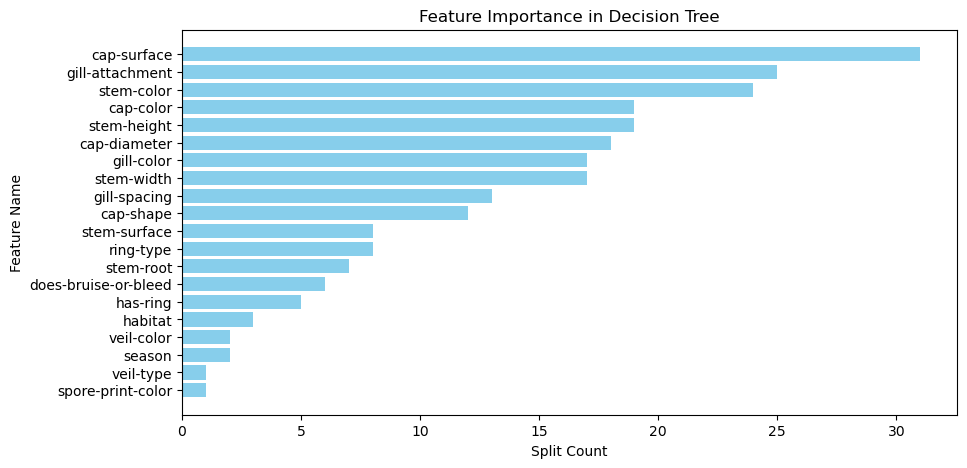

In [10]:
def plot_feature_importance(tree, feature_names):
    """Plots feature importance based on how often a feature is used in splits."""
    feature_counts = {i: 0 for i in range(len(feature_names))}
    
    def count_splits(node):
        """Recursively counts feature usage in splits."""
        if node is None or node.is_leaf():
            return
        feature_counts[node.feature] += 1
        count_splits(node.left)
        count_splits(node.right)

    count_splits(tree.root)

    features = np.array(list(feature_counts.keys()))
    counts = np.array(list(feature_counts.values()))

    sorted_indices = np.argsort(counts)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_counts = counts[sorted_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(sorted_features, sorted_counts, color="skyblue")
    plt.xlabel("Split Count")
    plt.ylabel("Feature Name")
    plt.title("Feature Importance in Decision Tree")
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(best_tree, df.drop(columns=['class']).columns)


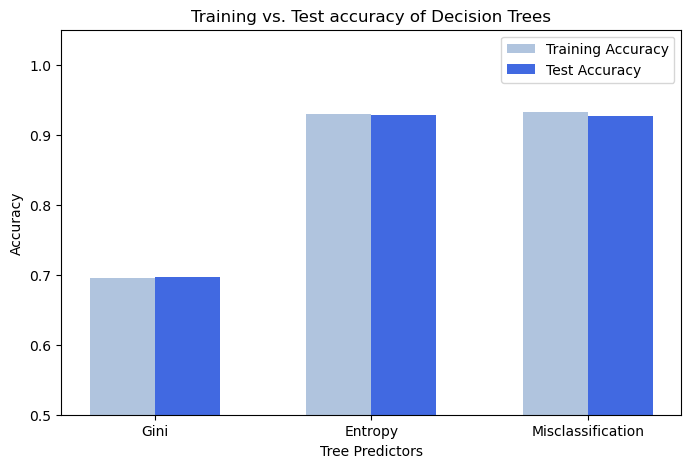

In [11]:
tree_names = ["Gini", "Entropy", "Misclassification"]
train_accuracies = [0.6952, 0.9296, 0.9322]
test_accuracies = [0.6964, 0.9277, 0.9265]

plt.figure(figsize=(8, 5))
x = np.arange(len(tree_names))
width = 0.3

plt.bar(x - width/2, train_accuracies, width, label="Training Accuracy", color='lightsteelblue')
plt.bar(x + width/2, test_accuracies, width, label="Test Accuracy", color='royalblue')

plt.xlabel("Tree Predictors")
plt.ylabel("Accuracy")
plt.title("Training vs. Test accuracy of Decision Trees")
plt.xticks(ticks=x, labels=tree_names)
plt.legend()
plt.ylim(0.5, 1.05)

plt.show()

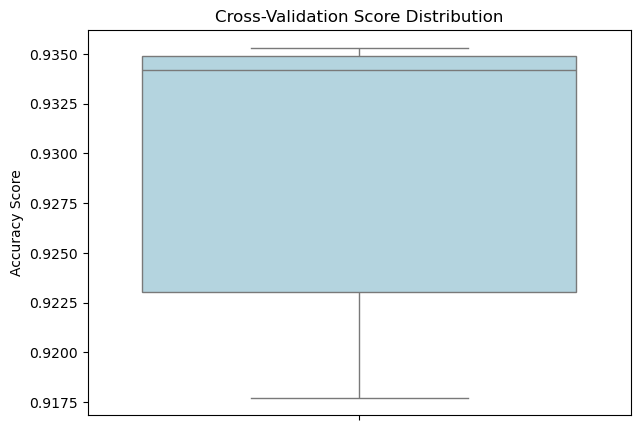

In [12]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=cv_scores, color="lightblue")
plt.title("Cross-Validation Score Distribution")
plt.ylabel("Accuracy Score")
plt.show()

In [13]:
tree_graph = visualize_tree(best_tree)
tree_graph.render("best_tree", format="png", cleanup=False)
tree_graph.view()

'best_tree.pdf'

/var/folders/wf/70l98_p931j_0zty1zh40ndc0000gn/T/ipykernel_91222/3191333366.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=["darkgreen", "darkred"])


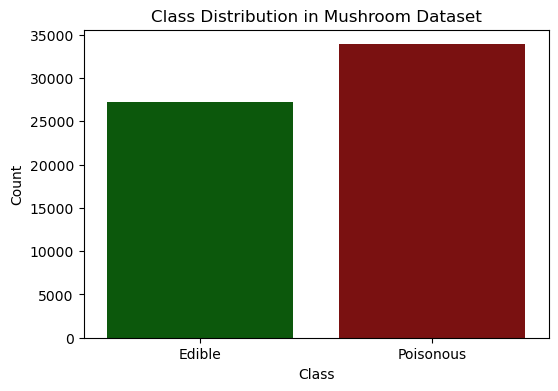

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=["darkgreen", "darkred"])
plt.xticks(ticks=[0,1], labels=["Edible", "Poisonous"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Mushroom Dataset")
plt.show()